In [1]:
%load_ext autoreload
%autoreload 2

In [190]:
import cv2
import sys
import os
import json
import torch
import numpy as np
from argparse import Namespace

root = "/Users/koombea/Desktop/emanuel/ai_pet/image_blending"
sys.path.append(root)

from blending.utils import plots as P
from blending.utils import image as I
from blending.utils import general as G

In [201]:
opt = Namespace(
    target_1 = "../../target_data/target_3.jpg",
    target_head_1 = "../../target_data/target_head_3.txt",
    normalize = False
)

# Load target image

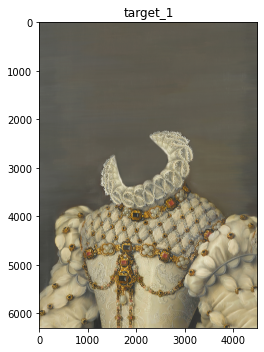

In [202]:
target_1 = I._numpy(I.load_image(path=opt.target_1))

P.plots_multiple_tensor_image(target_1,
                              title_name=["target_1"],
                              figsize=(10, 5), normalize=opt.normalize)

In [203]:
# x0y0x1y1 coords
tm_coords = G.load_target_head_dimensions(path=opt.target_head_1,
                                          image_shape = target_1.shape[:2])
tm_coords = tm_coords.astype(np.int32)

# Drawing Head bounding box

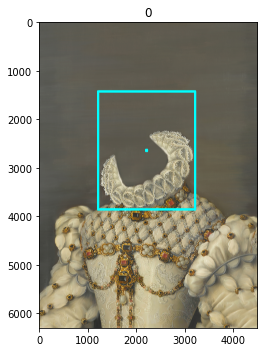

In [204]:
wtm, htm = (np.abs(tm_coords[0] - tm_coords[2]), 
           np.abs(tm_coords[1] - tm_coords[3]))

color = (0, 255, 255)
thickness = 50

# draw membrane
rect_target_1 = target_1.copy()
cv2.rectangle(rect_target_1, 
              (tm_coords[0], tm_coords[1]),
              (tm_coords[2], tm_coords[3]), color=color, thickness=thickness)

# draw membrane middel point
targetm_mp = G.get_middel_point(tm_coords.astype(np.float32))
cv2.drawMarker(rect_target_1, position=targetm_mp, 
              color=color, markerType=cv2.MARKER_STAR,
               markerSize=20, thickness=thickness)

P.plots_multiple_tensor_image(rect_target_1,
                              normalize = opt.normalize,
                             figsize=(10, 5))

# Saving

In [205]:
json.dump([int(xy) for xy in tm_coords],
                     open("../../target_data/target_head_3.json", "w"))

# Applying reshapes and reescale coords

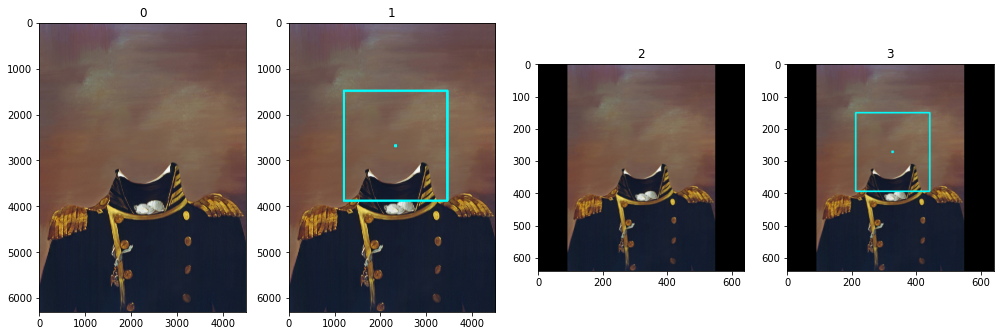

In [8]:
target_1_r = I._numpy(I.resize_pad_image(I._to_tensor(target_1), (640, 640)))
tmr_coords_1 = G.scale_coordinates(new_shape = (640, 640),
                            coordinates = tm_coords.astype(np.float32),
                            old_shape = target_1.shape[:2])
# Draw coordinates reshape
rect_target_1_r = target_1_r.copy()
cv2.rectangle(rect_target_1_r, tuple(tmr_coords_1[:2]),
              tuple(tmr_coords_1[2:]), color=color, thickness=4)

# draw middel point
targetmr_mp = G.get_middel_point(tmr_coords_1.astype(np.float32))
cv2.drawMarker(rect_target_1_r, position=targetmr_mp, 
              color=color, markerType=cv2.MARKER_STAR,
               markerSize=4, thickness=4)

P.plots_multiple_tensor_image(target_1, rect_target_1,
                              target_1_r, rect_target_1_r,
                              normalize = opt.normalize)

# Preprocess source and mask

## Load source data

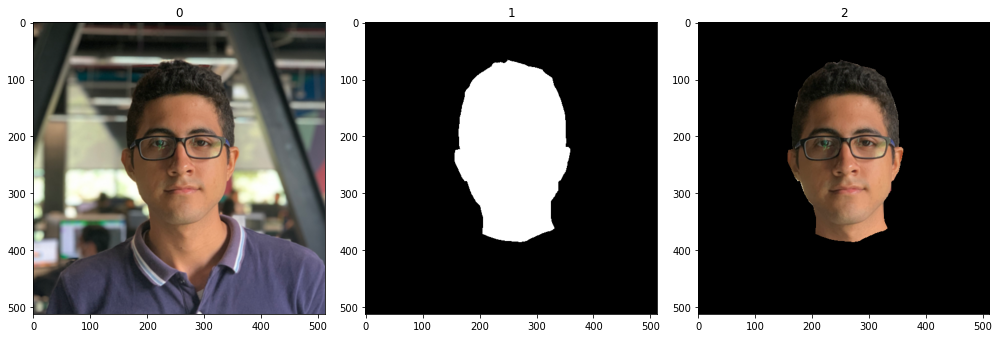

In [144]:
mask = I.load_image(path="../../source_data/mask_3.jpg",
                   is_mask=True)
source = I.load_image(path="../../source_data/source_3.jpg")

P.plots_multiple_tensor_image(source, mask, source * mask,
                              normalize=opt.normalize)

## Get contours and square bb from source and mask

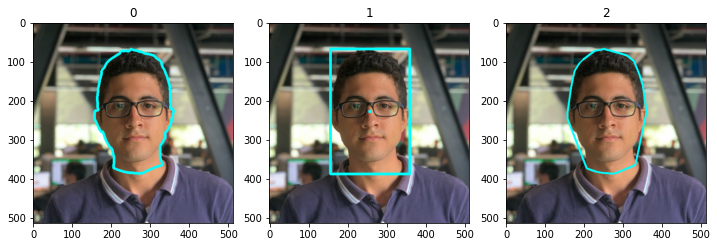

In [183]:
# Get countors
contours, hierarchy = cv2.findContours(image=I._numpy(mask).astype(np.uint8),
                                       mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Draw the contour 
source_contour = I._numpy(source).copy()
source_contour = cv2.drawContours(source_contour, contours, contourIdx=-1, 
                         color=color, thickness=5)

# Get bounding box for dominant contour
c_0 = contours[0]
# Get the 4 points of the Square bb
sm_coords = np.array(cv2.boundingRect(c_0), dtype=np.int32)
sm_coords = G.xywh2xyxy(sm_coords.astype(np.float32))

# Draw square rectangular box
source_rectangle = I._numpy(source).copy()
source_rectangle = cv2.rectangle(source_rectangle,
                                 (sm_coords[0], sm_coords[1]),
                                 (sm_coords[2], sm_coords[3]),
                        color=color, thickness=5)

# Draw middel point rectangular box
sourcem_mp = G.get_middel_point(sm_coords.astype(np.float32))
cv2.drawMarker(source_rectangle, position=sourcem_mp, 
              color=color, markerType=cv2.MARKER_STAR,
               markerSize=4, thickness=4)

# draw hull
hull = cv2.convexHull(c_0)
source_hull = I._numpy(source).copy()
source_hull = cv2.drawContours(source_hull, contours = [hull],
                              contourIdx = 0, color = color, thickness = 4)

P.plots_multiple_tensor_image(source_contour,
                              source_rectangle,
                              source_hull,
                              normalize=opt.normalize,
                              figsize=(10, 5))

In [188]:
hull_n = hull.reshape(-1, 2)
x_s = hull_n[:, 0]
y_s = hull_n[:, 1]
x_s.argmax(), y_s.argmin(), y_s.argmax()
hull_n[39]

array([250,  66], dtype=int32)

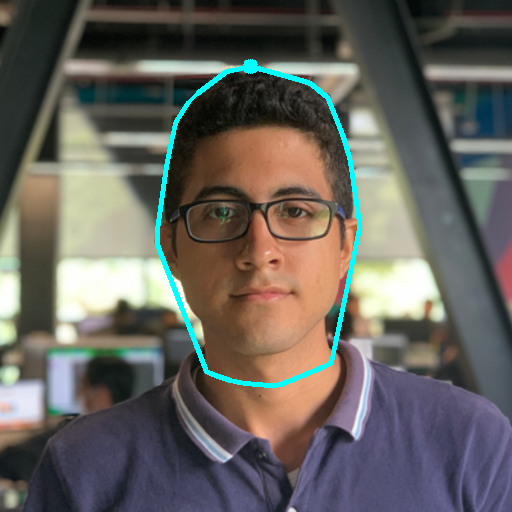

In [189]:
cv2.drawMarker(source_hull, position=(250,  66), color=color,
              markerType=cv2.MARKER_STAR,
               markerSize=4, thickness=10)
I._pil_image(source_hull/255.0)

## Delete Background from source

In [136]:
source_np = I._numpy(source).astype(np.uint8)
mask_np = I._numpy(mask).astype(np.uint8)

bgdModel = np.zeros(shape=(1, 65), dtype=np.float64)
fgdModel = np.zeros(shape=(1, 65), dtype=np.float64)

mask_grabcut, bgdModel, fgdModel = cv2.grabCut(source_np, mask=mask_np, rect=G.xyxy2xywh(sm_coords),
                                                bgdModel=bgdModel, fgdModel=fgdModel,
                                                iterCount=5,
                                                mode=cv2.GC_INIT_WITH_MASK)

mask_grabcut = np.where((mask_grabcut == 2)|(mask_grabcut == 0), 0, 1).astype(np.uint8)

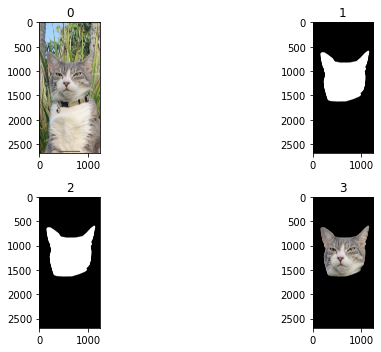

In [137]:
P.plots_multiple_tensor_image(source_np,
                              mask,
                              mask_grabcut,
                              source_np * mask_grabcut[:, :, np.newaxis],
                              normalize=opt.normalize,
                              figsize=(10, 5), ncols=2)

# Naive copy

## Accepted approach

Resize both dimensions to match target menbrane

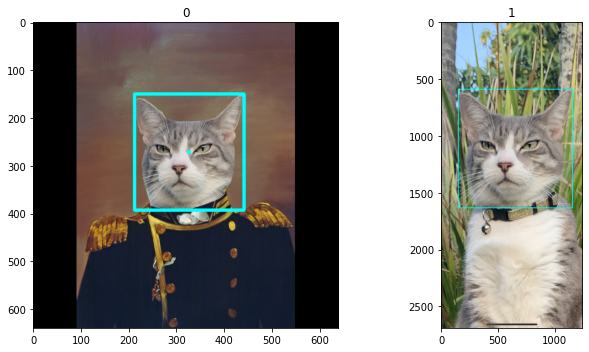

In [138]:
# Get dimensions
xt0, yt0, xt1, yt1 = tmr_coords_1.astype(np.int32)
xs0, ys0, xs1, ys1 = sm_coords.astype(np.int32)
wtm, htm = G.get_dimensions_box(np.array([xt0, yt0, xt1, yt1]))
wsm, hsm = G.get_dimensions_box(np.array([xs0, ys0, xs1, ys1]))

# Crop source and mask 
source_copy = source_np.astype(np.float32).copy()[ys0:ys1, xs0:xs1]
target_copy = target_1_r.astype(np.float32).copy()
mask_copy = mask_grabcut[:, :, np.newaxis].astype(np.float32).copy()[ys0:ys1, xs0:xs1]

mask_copy = I._numpy(I.resize_pad_image(mask_copy, new_shape=(htm, wtm)))[:, :, np.newaxis]
source_copy = I._numpy(I.resize_pad_image(source_copy, new_shape=(htm, wtm)))

# naive copy
target_copy[yt0:yt1, xt0:xt1, :] = (source_copy * mask_copy
                                          + target_copy[yt0:yt1, xt0:xt1, :] * (1 - mask_copy))

test = target_copy.copy()
# draw rectangle
cv2.rectangle(target_copy,
             (xt0, yt0),
             (xt1, yt1),
             color=color, thickness=5)

# draw middel point
cv2.drawMarker(target_copy, position=targetmr_mp, 
              color=color, markerType=cv2.MARKER_STAR,
               markerSize=4, thickness=4)

# plot
P.plots_multiple_tensor_image(target_copy, source_rectangle,
                              normalize=opt.normalize,
                              figsize=(10, 5))

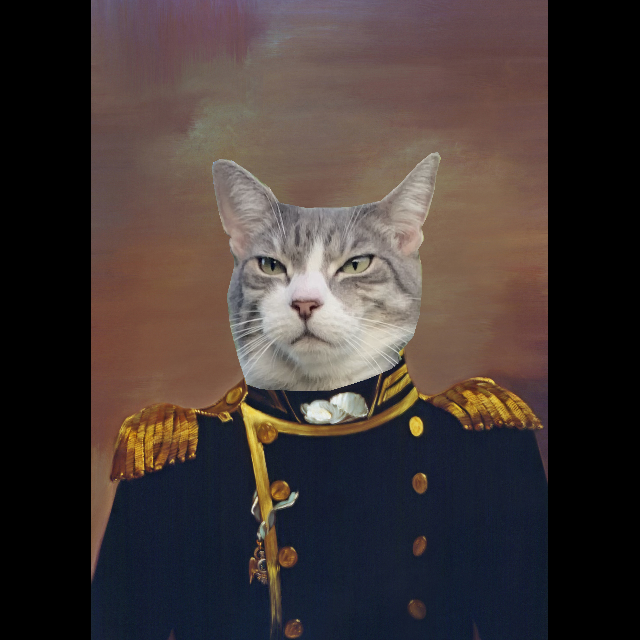

In [139]:
I._pil_image(test/255.0)